# Enhanced Demand Forecasting using XGBoost with Daily Data
This script performs demand forecasting using daily demand data combined with monthly economic indicators.

## Import Libraries and Load Data

In [55]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os

# Load daily data
daily_df = pd.read_excel(
    r"C:\Users\k_pow\OneDrive\Documents\MIT\MITx SCM\IAP 2025\SCC\Customer Order Quantity_Dispatched Quantity.xlsx"
)

# Filter for Material_4 ------------------------------------------------------------
material_id = '5551O2518'  # Material_4
material_no = 'Material_76'
daily_df = daily_df[daily_df['Product ID'] == material_id].copy()

# Convert date column
daily_df['Date'] = pd.to_datetime(daily_df['Date'], format='%d.%m.%Y')
daily_df.set_index('Date', inplace=True)
daily_df.sort_index(inplace=True)

# Load monthly data with external variables
monthly_df = pd.read_csv(f'C:\\Users\\k_pow\\OneDrive\\Documents\\MIT\\MITx SCM\\IAP 2025\\SCC\\Data_files\\{material_id}_{material_no}.csv')
monthly_df['YearMonth'] = pd.to_datetime(monthly_df['YearMonth'])
monthly_df.set_index('YearMonth', inplace=True)

print("Data loaded successfully.")
print("Daily data shape:", daily_df.shape)
print("Monthly data shape:", monthly_df.shape)

Data loaded successfully.
Daily data shape: (591, 7)
Monthly data shape: (95, 11)


In [56]:
daily_df

,Product ID,Product Name,Customer Order Quantity,Dispatched Quantity,Year,Month,Day
Date,,,,,,,
2022-01-06,5551O2518,Material_76,0,24,2022,1,6
2022-01-11,5551O2518,Material_76,8,8,2022,1,11
2022-01-12,5551O2518,Material_76,0,40,2022,1,12
2022-01-13,5551O2518,Material_76,40,16,2022,1,13
2022-01-14,5551O2518,Material_76,0,8,2022,1,14
...,...,...,...,...,...,...,...
2024-11-25,5551O2518,Material_76,0,32,2024,11,25
2024-11-26,5551O2518,Material_76,0,16,2024,11,26
2024-11-28,5551O2518,Material_76,0,48,2024,11,28


In [57]:
# Create a complete date range from the minimum to the maximum date
full_date_range = pd.date_range(start='2022-01-01', end='2024-12-05', freq='D')

# Reindex the dataframe to include all dates, filling missing values with 0
daily_df = daily_df.reindex(full_date_range, fill_value=0)

# Re-add the static 'Product ID' and 'Product Name' since they remain constant
daily_df['Product ID'] = material_no  
daily_df['Product Name'] = material_id  

# Re-add Year, Month, Day columns
daily_df['Year'] = daily_df.index.year
daily_df['Month'] = daily_df.index.month
daily_df['Day'] = daily_df.index.day

daily_df.head(60)

,Product ID,Product Name,Customer Order Quantity,Dispatched Quantity,Year,Month,Day
2022-01-01,Material_76,5551O2518,0,0,2022,1,1
2022-01-02,Material_76,5551O2518,0,0,2022,1,2
2022-01-03,Material_76,5551O2518,0,0,2022,1,3
2022-01-04,Material_76,5551O2518,0,0,2022,1,4
2022-01-05,Material_76,5551O2518,0,0,2022,1,5
2022-01-06,Material_76,5551O2518,0,24,2022,1,6
2022-01-07,Material_76,5551O2518,0,0,2022,1,7
2022-01-08,Material_76,5551O2518,0,0,2022,1,8
2022-01-09,Material_76,5551O2518,0,0,2022,1,9
2022-01-10,Material_76,5551O2518,0,0,2022,1,10


<Axes: xlabel='None', ylabel='Customer Order Quantity'>

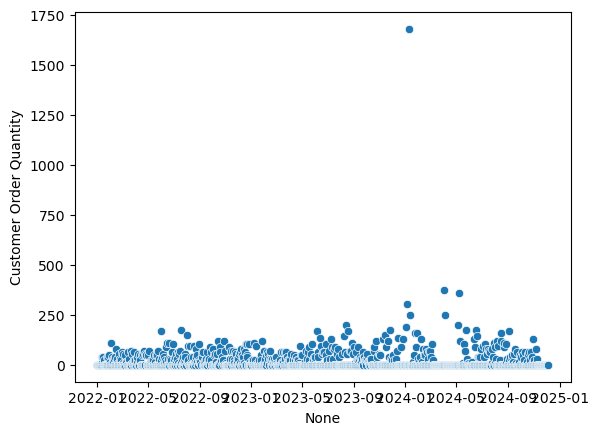

In [58]:
sns.scatterplot(x=daily_df.index, y=daily_df['Customer Order Quantity'])

In [59]:
monthly_df

,Product ID,Product Name,Dispatched Quantity,Customer Order Quantity,ECG_DESP,TUAV,PIB_CO,ISE_CO,VTOTAL_19,OTOTAL_19,ICI
YearMonth,,,,,,,,,,,
2017-01-01,5551O2518,Material_76,0.0,0.0,9.131904e+05,11303.0,14517.735830,100.730076,17178.0,133721.0,1.90
2017-02-01,5551O2518,Material_76,0.0,0.0,1.007968e+06,16187.0,14517.735830,101.167441,16175.0,130854.0,-0.10
2017-03-01,5551O2518,Material_76,0.0,0.0,1.083268e+06,15231.0,14517.735830,100.377762,15333.0,137551.0,-0.90
2017-04-01,5551O2518,Material_76,0.0,0.0,9.000049e+05,14093.0,14985.508742,103.507894,14456.0,135700.0,-8.50
2017-05-01,5551O2518,Material_76,0.0,0.0,9.990460e+05,13645.0,14985.508742,102.634285,14281.0,136432.0,-8.80
...,...,...,...,...,...,...,...,...,...,...,...
2024-07-01,5551O2518,Material_76,760.0,920.0,1.050528e+06,13092.0,10752.586638,74.110006,12248.0,165294.0,-1.19
2024-08-01,5551O2518,Material_76,904.0,904.0,1.074200e+06,14486.0,10752.586638,74.788896,13963.0,166207.0,-1.42
2024-09-01,5551O2518,Material_76,560.0,608.0,1.003767e+06,17833.0,10752.586638,73.813056,10856.0,166496.0,1.34


## Prepare Features

In [60]:
def prepare_features(data, monthly_data, is_training=True):
    """
    Prepare features combining daily and monthly data.
    is_training: bool, if False will not use future data for feature creation
    """
    features = pd.DataFrame(index=data.index)
    
    # Basic demand lags - for test data, we need to be careful about the boundary
    for lag in [1, 2, 3, 7, 14, 30]:  # Removed longer lags that might leak across train/test boundary
        features[f'Demand_lag_{lag}d'] = data['Dispatched Quantity'].shift(lag)


    # Rolling statistics - using only past data
    for window in [7, 14, 30]:  # Reduced windows to avoid boundary issues
        roll = data['Dispatched Quantity'].rolling(window=window, min_periods=1, closed='left')
        features[f'Demand_roll_mean_{window}d'] = roll.mean()
        features[f'Demand_roll_std_{window}d'] = roll.std()
    
    # External variables - careful with monthly data
    external_vars = ['ECG_DESP', 'TUAV', 'PIB_CO', 'ISE_CO', 'VTOTAL_19', 'OTOTAL_19', 'ICI']
    for var in external_vars:
        if var in monthly_data.columns:
            # Monthly lags - only use data from before current month
            for lag in range(1, 4):  # Reduced lag range to avoid leakage
                lagged = monthly_data[var].shift(lag)
                # For test data, we need to ensure we're not using future information
                if not is_training:
                    lagged = monthly_data[var].shift(lag + 1)  # Shift by (lag+1) in test mode
                else:
                    lagged = monthly_data[var].shift(lag)
                features[f'{var}_lag_{lag}m'] = lagged.reindex(data.index).fillna(method='ffill', limit=30)
    
    # Seasonality features - these are safe as they're based on the date
    features['Month'] = data.index.month
    features['Quarter'] = data.index.quarter
    features['WeekOfYear'] = data.index.isocalendar().week
    features['DayOfWeek'] = data.index.dayofweek
    features['DayOfMonth'] = data.index.day
    
    # Cyclical encoding - also safe as they're based on the date
    features['Month_sin'] = np.sin(2 * np.pi * data.index.month / 12)
    features['Month_cos'] = np.cos(2 * np.pi * data.index.month / 12)
    features['Day_sin'] = np.sin(2 * np.pi * data.index.dayofweek / 7)
    features['Day_cos'] = np.cos(2 * np.pi * data.index.dayofweek / 7)
    
    # Customer order features - only use recent lags
    for lag in [1, 2, 3, 7, 14]:
        features[f'Customer_Order_Lag{lag}'] = data['Customer Order Quantity'].shift(lag)
        if lag <= 7:  # Only compute ratios for short lags to avoid division issues
            ratio = (data['Customer Order Quantity'].shift(lag) / 
                    data['Dispatched Quantity'].shift(lag))
            features[f'Order_Demand_Ratio_Lag{lag}'] = ratio.replace([np.inf, -np.inf], np.nan)
    

    if not is_training:
        features = features.shift(1)  # Extra shift to prevent future info leak

    return features.fillna(0)

# Split data based on date first
train_cutoff = pd.to_datetime('2024-06-01')
train_mask = daily_df.index < train_cutoff

train_data = daily_df[train_mask].copy()
test_data = daily_df[~train_mask].copy()

# Split monthly data using the same cutoff
monthly_train_mask = monthly_df.index < train_cutoff
monthly_train_data = monthly_df[monthly_train_mask].copy()
monthly_test_data = monthly_df[~monthly_train_mask].copy()

# Create validation set from last month of training data
val_cutoff = train_cutoff - pd.DateOffset(months=1)
val_mask = (daily_df.index >= val_cutoff) & (daily_df.index < train_cutoff)
val_data = daily_df[val_mask].copy()
train_data = daily_df[daily_df.index < val_cutoff].copy()

# Split monthly data for validation
monthly_val_data = monthly_df[(monthly_df.index >= val_cutoff) & (monthly_df.index < train_cutoff)].copy()
monthly_train_data = monthly_df[monthly_df.index < val_cutoff].copy()

# Prepare features
X_train = prepare_features(train_data, monthly_train_data, is_training=True)
y_train = train_data['Dispatched Quantity']

X_val = prepare_features(val_data, monthly_val_data, is_training=False)
y_val = val_data['Dispatched Quantity']

X_test = prepare_features(test_data, monthly_test_data, is_training=False)
y_test = test_data['Dispatched Quantity']

print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Test data shape:", X_test.shape)

Training data shape: (851, 51)
Validation data shape: (31, 51)
Test data shape: (188, 51)


C:\Users\k_pow\AppData\Local\Temp\ipykernel_4592\4052551435.py:31: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features[f'{var}_lag_{lag}m'] = lagged.reindex(data.index).fillna(method='ffill', limit=30)
C:\Users\k_pow\AppData\Local\Temp\ipykernel_4592\4052551435.py:31: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features[f'{var}_lag_{lag}m'] = lagged.reindex(data.index).fillna(method='ffill', limit=30)
C:\Users\k_pow\AppData\Local\Temp\ipykernel_4592\4052551435.py:31: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features[f'{var}_lag_{lag}m'] = lagged.reindex(data.index).fillna(method='ffill', limit=30)
C:\Users\k_pow\AppData\Local\Temp\ipykernel_4592\4052551435.py:31: FutureWarning: Series.fillna with 'method' is depre

## Split Data and Train Model

In [61]:
# Train XGBoost model
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.05,
    max_depth=4,
    min_child_weight=2,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train the model
model.fit(
    X_train, 
    y_train,
    eval_set=[(X_val, y_val)],  # Use validation set instead of test set
    verbose=False
)

print("Model training completed")

Model training completed


## Evaluate Model at Multiple Time Scales

In [62]:
# Make daily predictions
daily_pred = model.predict(X_test)

# Create results DataFrame for daily predictions
test_start = pd.Timestamp('2024-06-01')
test_end = pd.Timestamp('2024-12-05')
daily_results = pd.DataFrame({
    'Date': X_test.index,
    'Actual': y_test,
    'Predicted': daily_pred
})
daily_results = daily_results[(daily_results['Date'] >= test_start) & (daily_results['Date'] <= test_end)]

# Aggregate to weekly - start from first Monday in June
weekly_df = daily_results.copy()
weekly_df.set_index('Date', inplace=True)
weekly_results = weekly_df.resample('W-MON').sum()
weekly_results = weekly_results.loc[test_start:test_end]
weekly_results = weekly_results.reset_index()

# Aggregate to monthly - start from June 1st
monthly_df = daily_results.copy()
monthly_df.set_index('Date', inplace=True)
# Use MS (Month Start) to align with the 1st of each month
monthly_results = monthly_df.resample('MS').sum()
monthly_results = monthly_results.loc[test_start:test_end]
monthly_results = monthly_results.reset_index()

print("\nDaily Results Date Range:")
print(daily_results['Date'].min(), "to", daily_results['Date'].max())
print("\nMonthly Results Date Range:")
print(monthly_results['Date'].min(), "to", monthly_results['Date'].max())

print("\nAggregation Info:")
print(f"Daily predictions: {len(daily_results)} days")
print(f"Weeks: {len(weekly_results)} weeks")
print(f"Months: {len(monthly_results)} months")

# Function to calculate metrics including Excel-style R²
def calculate_metrics(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    # Calculate R² as the square of correlation coefficient (Excel method)
    r2 = np.corrcoef(actual, predicted)[0, 1] ** 2
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }

# Calculate metrics for daily predictions
daily_metrics = calculate_metrics(daily_results['Actual'], daily_results['Predicted'])
print("\nDaily Metrics:")
print(f"RMSE: {daily_metrics['RMSE']:.2f}")
print(f"MAE: {daily_metrics['MAE']:.2f}")
print(f"R2 (correlation squared): {daily_metrics['R2']:.3f}")

# Calculate metrics for weekly predictions
weekly_metrics = calculate_metrics(weekly_results['Actual'], weekly_results['Predicted'])
print("\nWeekly Metrics:")
print(f"RMSE: {weekly_metrics['RMSE']:.2f}")
print(f"MAE: {weekly_metrics['MAE']:.2f}")
print(f"R2 (correlation squared): {weekly_metrics['R2']:.3f}")

# Calculate metrics for monthly predictions
monthly_metrics = calculate_metrics(monthly_results['Actual'], monthly_results['Predicted'])
print("\nMonthly Metrics:")
print(f"RMSE: {monthly_metrics['RMSE']:.2f}")
print(f"MAE: {monthly_metrics['MAE']:.2f}")
print(f"R2 (correlation squared): {monthly_metrics['R2']:.3f}")

# Also save metrics to CSV for verification
metrics_df = pd.DataFrame({
    'Timeframe': ['Daily', 'Weekly', 'Monthly'],
    'RMSE': [daily_metrics['RMSE'], weekly_metrics['RMSE'], monthly_metrics['RMSE']],
    'MAE': [daily_metrics['MAE'], weekly_metrics['MAE'], monthly_metrics['MAE']],
    'R2': [daily_metrics['R2'], weekly_metrics['R2'], monthly_metrics['R2']]
})

# output_dir = os.path.join(os.path.dirname(__file__), 'predictions')
# os.makedirs(output_dir, exist_ok=True)

# metrics_output = os.path.join(output_dir, 'prediction_metrics.csv')
# metrics_df.to_csv(metrics_output, index=False)
# print(f"\nSaved metrics to: {metrics_output}")

# # Save predictions to CSV files
# daily_output = os.path.join(output_dir, 'daily_predictions.csv')
# daily_results.to_csv(daily_output, index=True)
# print(f"\nSaved daily predictions to: {daily_output}")

# weekly_output = os.path.join(output_dir, 'weekly_predictions.csv')
# weekly_results.to_csv(weekly_output, index=False)
# print(f"Saved weekly predictions to: {weekly_output}")

# monthly_output = os.path.join(output_dir, 'monthly_predictions.csv')
# monthly_results.to_csv(monthly_output, index=False)
# print(f"Saved monthly predictions to: {monthly_output}")

# Print summary statistics
print("\nSummary of predictions:")
print(f"Daily predictions: {len(daily_results)} days")
print(f"Weekly predictions: {len(weekly_results)} weeks")
print(f"Monthly predictions: {len(monthly_results)} months")

# Calculate and print total demand for each timeframe
print("\nTotal Demand:")
print(f"Daily - Actual: {daily_results['Actual'].sum():,.0f}, Predicted: {daily_results['Predicted'].sum():,.0f}")
print(f"Weekly - Actual: {weekly_results['Actual'].sum():,.0f}, Predicted: {weekly_results['Predicted'].sum():,.0f}")
print(f"Monthly - Actual: {monthly_results['Actual'].sum():,.0f}, Predicted: {monthly_results['Predicted'].sum():,.0f}")


Daily Results Date Range:
2024-06-01 00:00:00 to 2024-12-05 00:00:00

Monthly Results Date Range:
2024-06-01 00:00:00 to 2024-12-01 00:00:00

Aggregation Info:
Daily predictions: 188 days
Weeks: 27 weeks
Months: 7 months

Daily Metrics:
RMSE: 41.30
MAE: 28.72
R2 (correlation squared): 0.014

Weekly Metrics:
RMSE: 82.68
MAE: 60.79
R2 (correlation squared): 0.281

Monthly Metrics:
RMSE: 144.80
MAE: 114.35
R2 (correlation squared): 0.914

Summary of predictions:
Daily predictions: 188 days
Weekly predictions: 27 weeks
Monthly predictions: 7 months

Total Demand:
Daily - Actual: 4,344, Predicted: 3,621
Weekly - Actual: 4,320, Predicted: 3,604
Monthly - Actual: 4,344, Predicted: 3,621


## Visualize Predictions at Different Time Scales

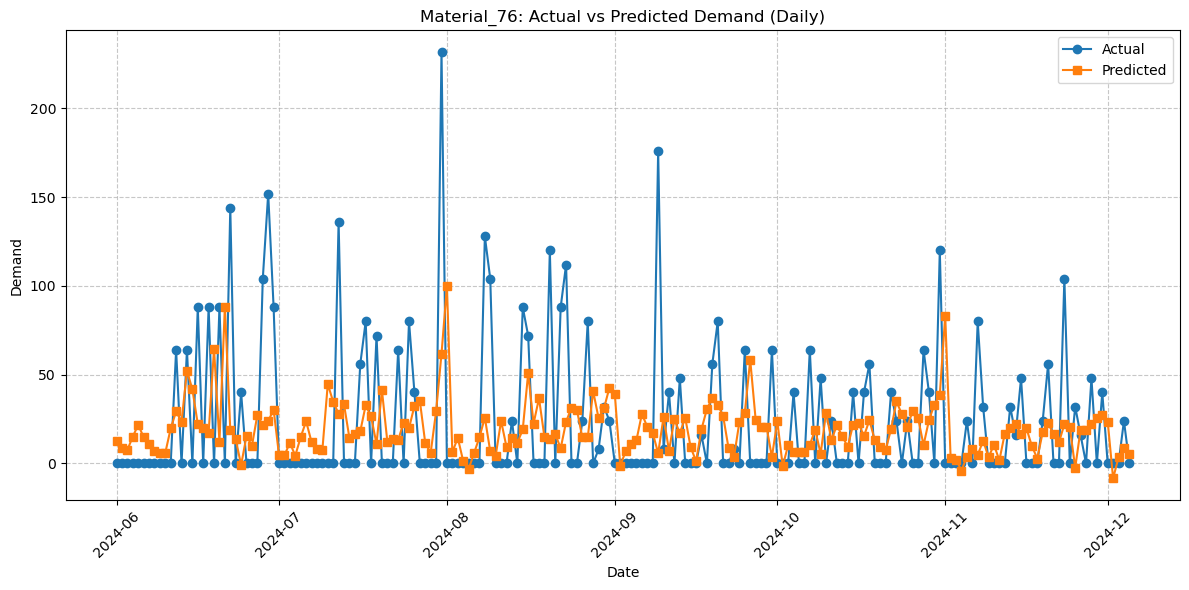


Daily Results:
Date range: 2024-06-01 00:00:00 to 2024-12-05 00:00:00
                 Date  Actual  Predicted
2024-06-01 2024-06-01       0  12.525025
2024-06-02 2024-06-02       0   8.765597
2024-06-03 2024-06-03       0   7.639358
2024-06-04 2024-06-04       0  15.109426
2024-06-05 2024-06-05       0  21.788612
2024-06-06 2024-06-06       0  14.780015
2024-06-07 2024-06-07       0  10.758595
2024-06-08 2024-06-08       0   7.277812
2024-06-09 2024-06-09       0   6.072210
2024-06-10 2024-06-10       0   5.960843
2024-06-11 2024-06-11       0  19.734758
2024-06-12 2024-06-12      64  29.307053
2024-06-13 2024-06-13       0  23.402500
2024-06-14 2024-06-14      64  52.205368
2024-06-15 2024-06-15       0  41.796761
2024-06-16 2024-06-16      88  22.175571
2024-06-17 2024-06-17       0  19.759258
2024-06-18 2024-06-18      88  17.159782
2024-06-19 2024-06-19       0  64.433723
2024-06-20 2024-06-20      88  12.117417
2024-06-21 2024-06-21       0  88.391106
2024-06-22 2024-06-22     1

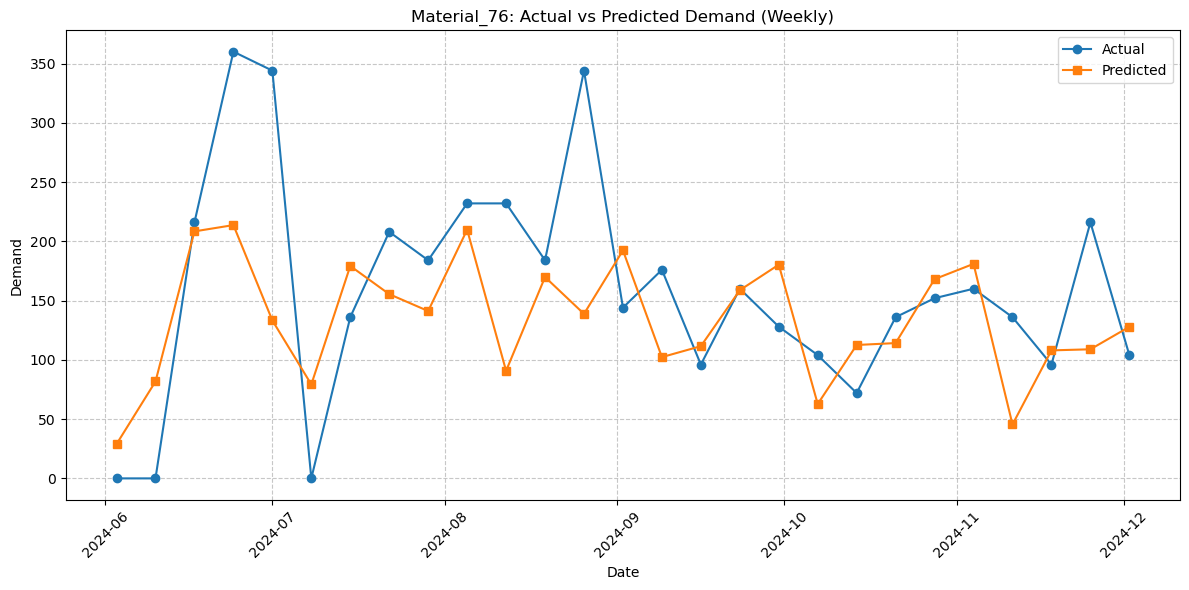


Weekly Results:
Date range: 2024-06-03 00:00:00 to 2024-12-02 00:00:00
         Date  Actual   Predicted
0  2024-06-03       0   28.929981
1  2024-06-10       0   81.747513
2  2024-06-17     216  208.381271
3  2024-06-24     360  213.693710
4  2024-07-01     344  133.249588
5  2024-07-08       0   79.241623
6  2024-07-15     136  179.198044
7  2024-07-22     208  155.422684
8  2024-07-29     184  141.183990
9  2024-08-05     232  209.803757
10 2024-08-12     232   90.723946
11 2024-08-19     184  169.864853
12 2024-08-26     344  138.776779
13 2024-09-02     144  192.349411
14 2024-09-09     176  102.304108
15 2024-09-16      96  111.534843
16 2024-09-23     160  158.766891
17 2024-09-30     128  180.288300
18 2024-10-07     104   62.739750
19 2024-10-14      72  112.543221
20 2024-10-21     136  114.145706
21 2024-10-28     152  168.090607
22 2024-11-04     160  180.969940
23 2024-11-11     136   45.482956
24 2024-11-18      96  107.992584
25 2024-11-25     216  108.909615
26 2024-12

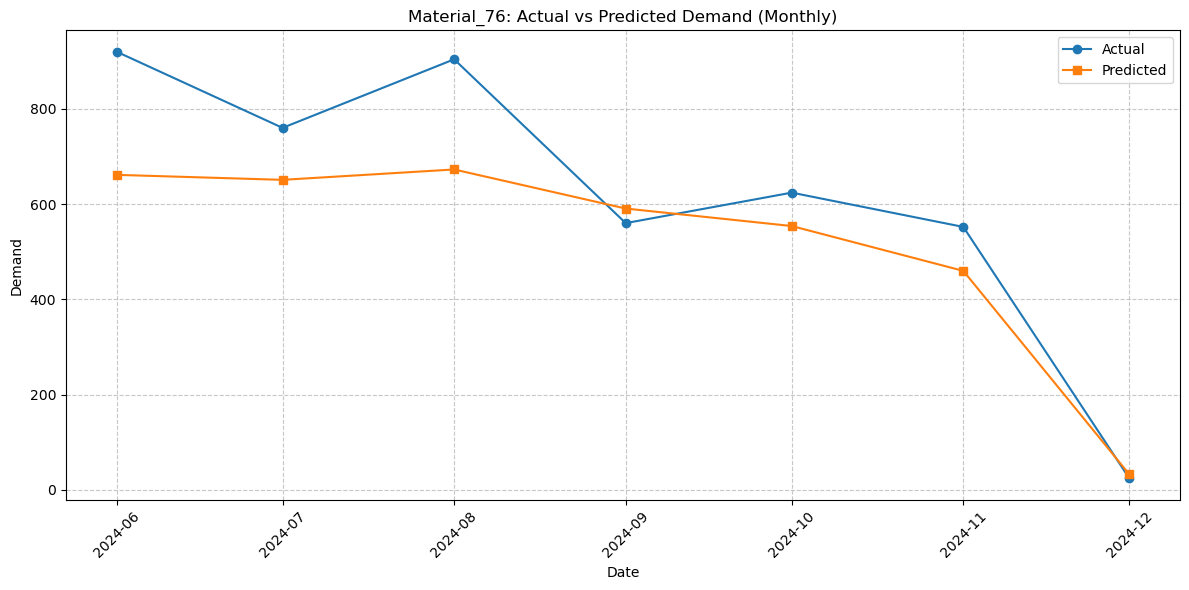


Monthly Results:
Date range: 2024-06-01 00:00:00 to 2024-12-01 00:00:00
        Date  Actual   Predicted
0 2024-06-01     920  661.343567
1 2024-07-01     760  650.863586
2 2024-08-01     904  672.646912
3 2024-09-01     560  590.607239
4 2024-10-01     624  553.889648
5 2024-11-01     552  459.708771
6 2024-12-01      24   32.289902


In [63]:
def plot_predictions(results, title, freq):
    plt.figure(figsize=(12, 6))
    plt.plot(results['Date'], results['Actual'], label='Actual', marker='o')
    plt.plot(results['Date'], results['Predicted'], label='Predicted', marker='s')
    plt.title(f'{material_no}: Actual vs Predicted Demand ({freq})')
    plt.xlabel('Date')
    plt.ylabel('Demand')
    plt.legend()
    
    # Just rotate the existing dates for readability
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Print actual dates and values
    print(f"\n{freq} Results:")
    print("Date range:", results['Date'].min(), "to", results['Date'].max())
    print(results[['Date', 'Actual', 'Predicted']].to_string())

# Plot results at different time scales
plot_predictions(daily_results, 'Daily Predictions', 'Daily')
plot_predictions(weekly_results, 'Weekly Predictions', 'Weekly')
plot_predictions(monthly_results, 'Monthly Predictions', 'Monthly')

## Analyze Residuals

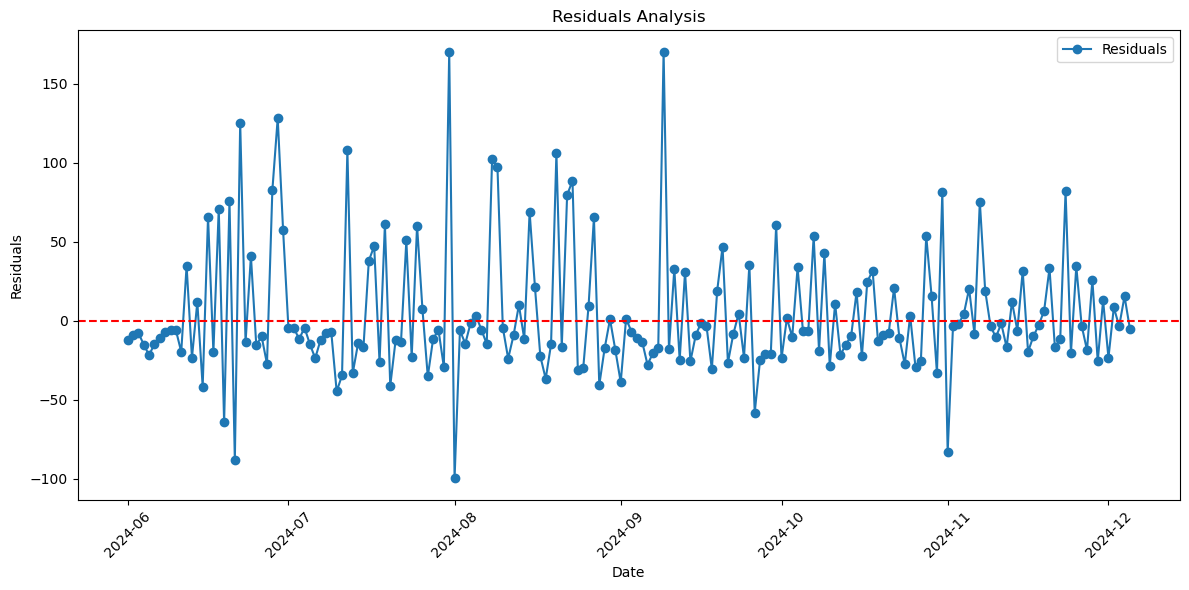

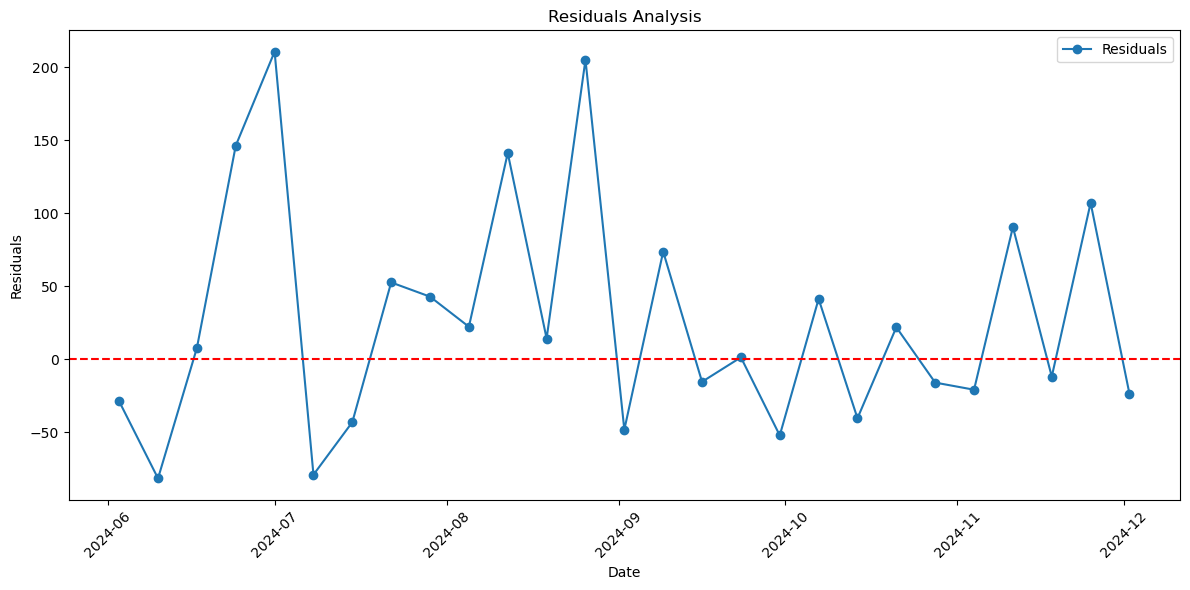

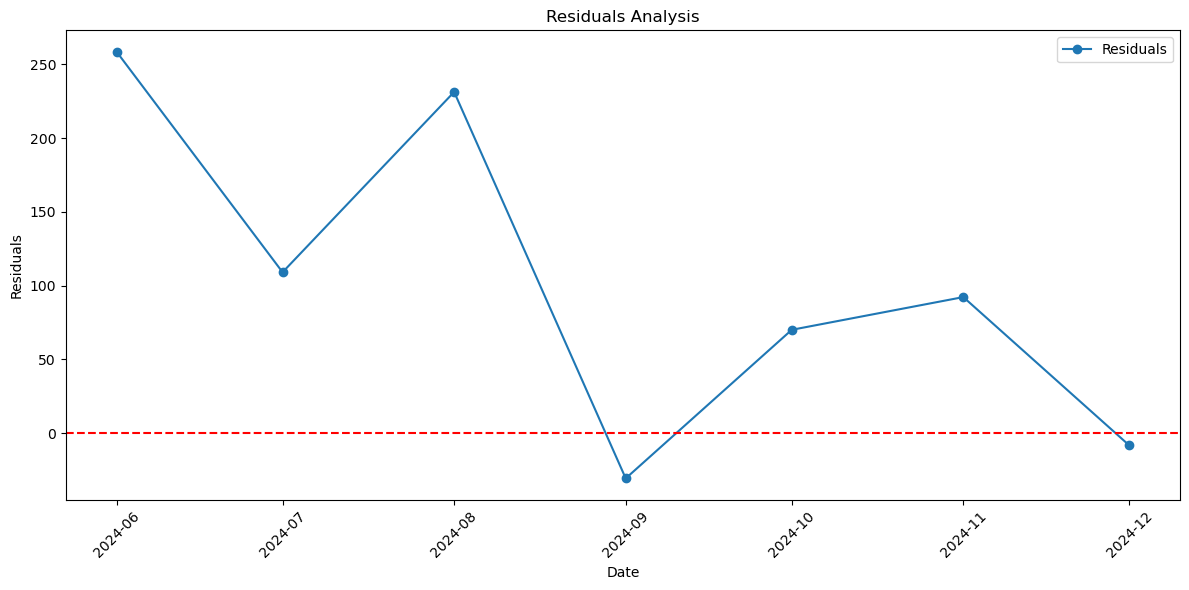

In [64]:
def analyze_residuals(results):
    residuals = results['Actual'] - results['Predicted']
    plt.figure(figsize=(12, 6))
    plt.plot(results['Date'], residuals, label='Residuals', marker='o')
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Residuals Analysis')
    plt.xlabel('Date')
    plt.ylabel('Residuals')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Analyze residuals for each time scale
analyze_residuals(daily_results)
analyze_residuals(weekly_results)
analyze_residuals(monthly_results)

## Simplify the Model (Optional)


Simpler Model Daily Metrics:
RMSE: 41.60
MAE: 28.25
R2 (correlation squared): 0.014


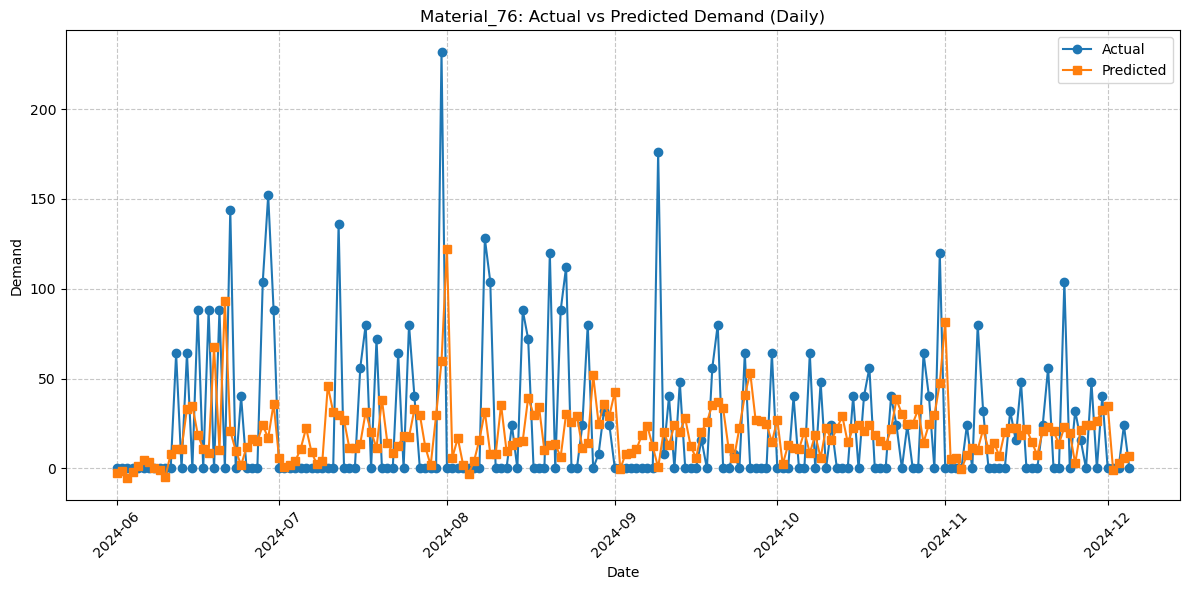


Daily Results:
Date range: 2024-06-01 00:00:00 to 2024-12-05 00:00:00
                 Date  Actual   Predicted
2024-06-01 2024-06-01       0   -2.434212
2024-06-02 2024-06-02       0   -1.507506
2024-06-03 2024-06-03       0   -5.597760
2024-06-04 2024-06-04       0   -2.204373
2024-06-05 2024-06-05       0    1.490442
2024-06-06 2024-06-06       0    4.472259
2024-06-07 2024-06-07       0    3.281471
2024-06-08 2024-06-08       0    0.283523
2024-06-09 2024-06-09       0   -0.807386
2024-06-10 2024-06-10       0   -4.802853
2024-06-11 2024-06-11       0    7.990042
2024-06-12 2024-06-12      64   10.987989
2024-06-13 2024-06-13       0   10.987989
2024-06-14 2024-06-14      64   33.160225
2024-06-15 2024-06-15       0   34.804203
2024-06-16 2024-06-16      88   18.820925
2024-06-17 2024-06-17       0   10.853662
2024-06-18 2024-06-18      88    8.432724
2024-06-19 2024-06-19       0   67.411263
2024-06-20 2024-06-20      88   10.329671
2024-06-21 2024-06-21       0   93.116020
2024-

In [65]:
# Train a simpler XGBoost model
simple_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=50,  # Reduced number of estimators
    learning_rate=0.1,  # Adjusted learning rate
    max_depth=3,  # Reduced max depth
    min_child_weight=1,  # Adjusted min child weight
    subsample=0.9,  # Adjusted subsample
    colsample_bytree=0.9,  # Adjusted colsample
    random_state=42
)

# Train the simpler model
simple_model.fit(
    X_train, 
    y_train,
    eval_set=[(X_val, y_val)],  # Use validation set instead of test set
    verbose=False
)

# Make predictions with the simpler model
simple_daily_pred = simple_model.predict(X_test)

# Create DataFrames with actual and predicted values for the simpler model
simple_daily_results = pd.DataFrame({
    'Date': X_test.index,
    'Actual': y_test,
    'Predicted': simple_daily_pred
})

# Filter for actual test period
test_start = pd.Timestamp('2024-06-01')
test_end = pd.Timestamp('2024-12-05')
simple_daily_results = simple_daily_results[(simple_daily_results['Date'] >= test_start) & (simple_daily_results['Date'] <= test_end)]

# Calculate metrics for the simpler model
simple_daily_metrics = calculate_metrics(simple_daily_results['Actual'], simple_daily_results['Predicted'])

print("\nSimpler Model Daily Metrics:")
print(f"RMSE: {simple_daily_metrics['RMSE']:.2f}")
print(f"MAE: {simple_daily_metrics['MAE']:.2f}")
print(f"R2 (correlation squared): {simple_daily_metrics['R2']:.3f}")

# Plot predictions for the simpler model
plot_predictions(simple_daily_results, 'Daily Predictions (Simpler Model)', 'Daily')

## Feature Importance Analysis

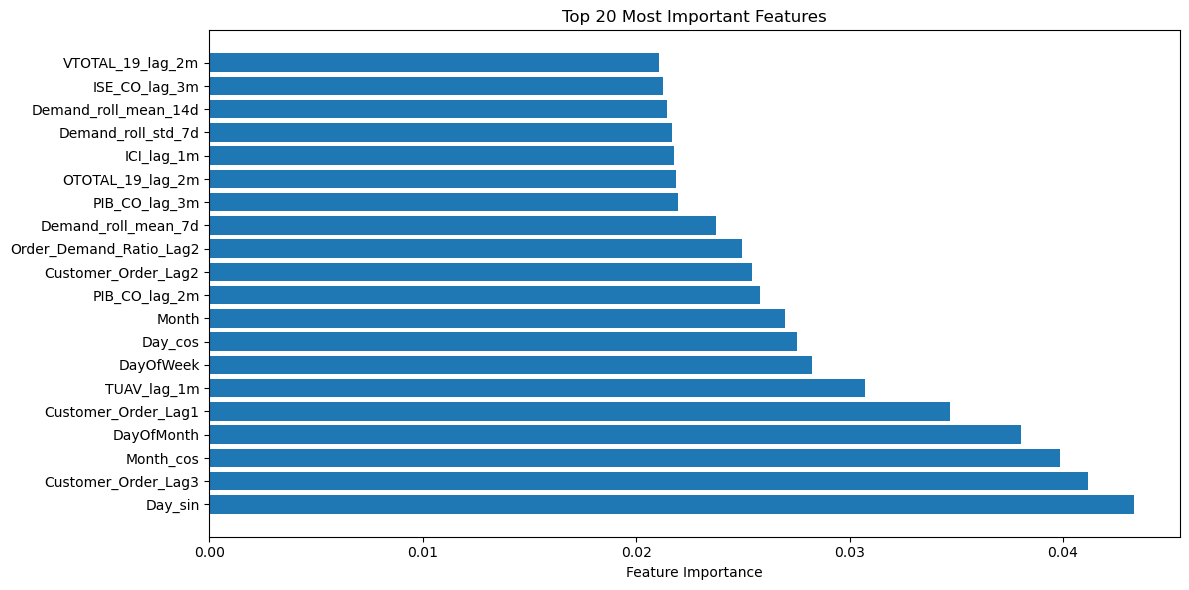


Top 10 Most Important Features:
                feature  importance
40              Day_sin    0.043321
46  Customer_Order_Lag3    0.041167
39            Month_cos    0.039864
37           DayOfMonth    0.038026
42  Customer_Order_Lag1    0.034714
15          TUAV_lag_1m    0.030715
36            DayOfWeek    0.028259
41              Day_cos    0.027556
33                Month    0.026988
19        PIB_CO_lag_2m    0.025803


In [66]:
# Get feature importance
importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(12, 6))
plt.barh(importance.head(20)['feature'], importance.head(20)['importance'])
plt.title('Top 20 Most Important Features')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(importance.head(10))